In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
selectall=session.query(Station).first()
selectall.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x168ec9f3bb0>,
 'elevation': 3.0,
 'id': 1,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

In [11]:
selectall=session.query(Measurement).first()
selectall.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x168eca01940>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
most_curr_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_curr_date = str(most_curr_date)[2:-3]
print(most_curr_date)

2017-08-23


In [13]:
year_from_current = str(eval(most_curr_date[0:4])-1) + most_curr_date[4:]
print(year_from_current)

2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
prcp_last_12months = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_from_current).filter(Measurement.date <= most_curr_date).order_by(Measurement.date).all()
print(prcp_last_12months[0], prcp_last_12months[2229])

('2016-08-23', 0.0) ('2017-08-23', 0.45)


In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_last_12months_df = pd.DataFrame(data = prcp_last_12months)
prcp_last_12months_df.set_index("date", inplace = True)
prcp_last_12months_df.rename(columns={"prcp": "Precipitation"}, inplace = True)
prcp_last_12months_df.head()

,Precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


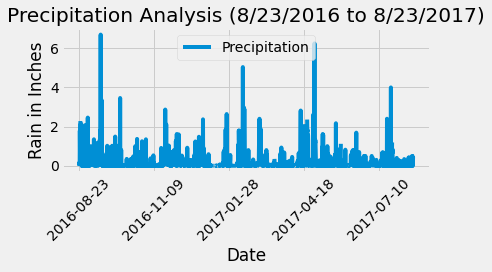

In [31]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_last_12months_df.plot()
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/23/2016 to 8/23/2017)")
plt.legend(loc=9)
# plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Precipitation_Analysis.png")
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_last_12months_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [33]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Station.station))
station_count = stations[0]
station_count

(9)

In [32]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
observations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())

for station in observations:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_station = observations[0][0]

stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == top_station)
                      
stats_list=list(stats)
print(stats_list)

[(54.0, 85.0, 71.66378066378067)]


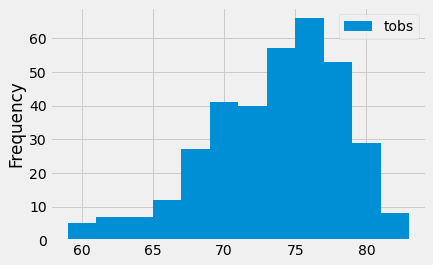

<Figure size 432x288 with 0 Axes>

In [36]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.tobs).filter(Measurement.date >= year_from_current).filter(Measurement.date <= most_curr_date).filter(Measurement.station == top_station)

tobs_list = []
for tob in tobs:
    tobs_list.append(tob[0])
    
fig = plt.figure()
plt.hist(tobs_list, bins=12 , label='tobs')
plt.ylabel("Frequency")
plt.legend(loc=1)
plt.show()
plt.savefig("Station_Observation_Analysis.png")

## Bonus Challenge Assignment

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
start_date = '2012-02-28'
end_date = '2012-03-05'
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [38]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start = str(eval(start_date[0:4])-1) + start_date[4:]
prev_year_end = str(eval(end_date[0:4])-1) + end_date[4:]

last_year_temp_analysis = calc_temps(prev_year_start, prev_year_end)

tmin = last_year_temp_analysis[0][0]
tmax = last_year_temp_analysis[0][1]
tavg = last_year_temp_analysis[0][2]

print(last_year_temp_analysis)

[(61.0, 69.75510204081633, 75.0)]


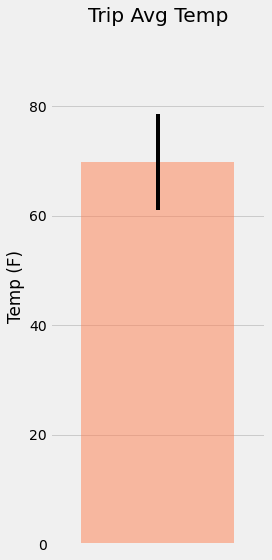

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))

bar= ax.bar(1, tmax, yerr=(tmax-tmin),alpha=0.5, color="coral")
ax.set(xticks=range(1), xticklabels="a", title="Trip Avg Temp", ylabel = "Temp (F)")
ax.margins(.2,.2)
fig.tight_layout()

plt.savefig("Temperature_Analysis.png")
plt.show()

In [41]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_prcp = pd.read_sql("select s.station, sum(prcp) from Measurement m join Station s on m.station = s.station where date between '2017-02-01' and '2017-02-10' group by s.station ", session.bind)
total_prcp

,station,sum(prcp)
0,USC00513117,2.34
1,USC00514830,0.94
2,USC00516128,1.79
3,USC00517948,0.00
4,USC00519281,1.50
5,USC00519397,0.51
6,USC00519523,1.80


In [42]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [44]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2016-01-01'
end_date ='2016-01-07'
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
dates = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()

trip_dates = [x[0] for x in dates]
trip_dates_stripped= [x[5:] for x in trip_dates]

# Find the start month/day and the end month/day 
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date    
daily_normals = [session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
daily_normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [45]:
 # Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
# Create a dataframe from the previous query 
temp_df= pd.DataFrame(daily_normals,columns=['min_temp', 'avg_temp', 'max_temp'])

# Add trip_dates to Pandas DataFrame
temp_df['date']= trip_dates

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
temp_df['date'] = pd.to_datetime(temp_df['date'], format='%Y-%m-%d')

# Set index to date
temp_df.set_index('date',inplace=True)

temp_df

,min_temp,avg_temp,max_temp
date,,,
2016-01-01,62.0,69.153846,77.0
2016-01-02,60.0,69.396226,77.0
2016-01-03,62.0,68.909091,77.0
2016-01-04,58.0,70.000000,76.0
2016-01-05,56.0,67.964286,76.0
2016-01-06,61.0,68.964912,76.0
2016-01-07,57.0,68.543860,76.0


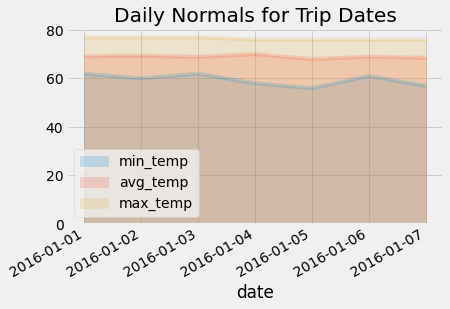

In [46]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Plot the daily normals as an area plot with `stacked=False`
temp_df.plot(kind='area', alpha=0.2, stacked=False, x_compat=True, title="Daily Normals for Trip Dates")
plt.savefig("DailyNormals.png")
plt.show()